In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC  # Más eficiente que SVC con kernel lineal
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_selection import SelectKBest, f_classif
from joblib import Parallel, delayed
import time
import warnings

warnings.filterwarnings("ignore")

print("Librerías importadas correctamente")

Librerías importadas correctamente


In [9]:
class RTIoTClassifier:
    def __init__(self, n_jobs=-1, use_feature_selection=True):
        self.n_jobs = n_jobs if n_jobs != -1 else self._get_optimal_jobs()
        self.use_feature_selection = use_feature_selection
        print(f"Configurado para usar {self.n_jobs} trabajos en paralelo")

        # Modelos optimizados para datasets grandes
        self.models = {
            "LogisticRegression": LogisticRegression(
                max_iter=500, random_state=42, n_jobs=self.n_jobs
            ),
            "RandomForest": RandomForestClassifier(
                n_estimators=50, random_state=42, n_jobs=self.n_jobs
            ),
            "SVM_Linear_Optimized": LinearSVC(
                random_state=42, max_iter=1000, dual=False
            ),  # dual=False para n_samples > n_features
            "DecisionTree": DecisionTreeClassifier(random_state=42, max_depth=20),
            "KNN": KNeighborsClassifier(n_neighbors=5, n_jobs=self.n_jobs),
        }
        self.scaler = StandardScaler()
        self.label_encoder = LabelEncoder()
        self.feature_selector = None
        self.results = {}

    def _get_optimal_jobs(self):
        """Determinar el número óptimo de trabajos paralelos"""
        import os

        return min(4, os.cpu_count() - 1 if os.cpu_count() > 1 else 1)

    def load_and_preprocess_data(self, train_path, test_path, max_features=100):
        """Cargar y preprocesar datos con selección de características"""
        print("Cargando dataset RT-IoT2022...")

        # Cargar datos
        train_df = pd.read_csv(train_path, low_memory=False)
        test_df = pd.read_csv(test_path, low_memory=False)

        print(f"Dimensiones Train: {train_df.shape}")
        print(f"Dimensiones Test: {test_df.shape}")

        # Optimizar uso de memoria
        train_df = self._optimize_dataframe(train_df)
        test_df = self._optimize_dataframe(test_df)

        # Separar características y target
        X_train = train_df.drop("Attack_type", axis=1)
        y_train = train_df["Attack_type"]

        if "Attack_type" in test_df.columns:
            X_test = test_df.drop("Attack_type", axis=1)
            y_test = test_df["Attack_type"]
        else:
            X_test = test_df
            y_test = None

        # Preprocesamiento con selección de características
        X_train_processed, X_test_processed, y_train_encoded, y_test_encoded = (
            self._preprocess_with_feature_selection(
                X_train, X_test, y_train, y_test, max_features
            )
        )

        return (
            X_train_processed,
            X_test_processed,
            y_train_encoded,
            y_test_encoded,
            y_test,
        )

    def _optimize_dataframe(self, df):
        """Optimizar tipos de datos para reducir uso de memoria"""
        numeric_columns = df.select_dtypes(include=[np.number]).columns
        for col in numeric_columns:
            if df[col].dtype == "float64":
                df[col] = df[col].astype("float32")
            elif df[col].dtype == "int64":
                col_min = df[col].min()
                col_max = df[col].max()
                if col_min >= 0:
                    if col_max < 256:
                        df[col] = df[col].astype("uint8")
                    elif col_max < 65536:
                        df[col] = df[col].astype("uint16")
                    else:
                        df[col] = df[col].astype("uint32")
                else:
                    if col_min > -128 and col_max < 127:
                        df[col] = df[col].astype("int8")
                    elif col_min > -32768 and col_max < 32767:
                        df[col] = df[col].astype("int16")
                    else:
                        df[col] = df[col].astype("int32")
        return df

    def _preprocess_with_feature_selection(
        self, X_train, X_test, y_train, y_test, max_features
    ):
        """Preprocesamiento con selección de características para acelerar SVM"""
        print("Iniciando preprocesamiento con selección de características...")

        numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
        categorical_features = X_train.select_dtypes(
            include=["object", "bool"]
        ).columns.tolist()

        print(f"Características numéricas: {len(numeric_features)}")
        print(f"Características categóricas: {len(categorical_features)}")

        # Codificar características categóricas
        for col in categorical_features:
            if col in X_train.columns:
                le = LabelEncoder()
                combined = pd.concat([X_train[col], X_test[col]], axis=0)
                le.fit(combined.astype(str))
                X_train[col] = le.transform(X_train[col].astype(str))
                X_test[col] = le.transform(X_test[col].astype(str))

        # Escalar características numéricas
        X_train_scaled = X_train.copy()
        X_test_scaled = X_test.copy()

        if numeric_features:
            X_train_scaled[numeric_features] = self.scaler.fit_transform(
                X_train[numeric_features]
            )
            X_test_scaled[numeric_features] = self.scaler.transform(
                X_test[numeric_features]
            )

        # Manejar valores NaN
        X_train_scaled = X_train_scaled.fillna(0)
        X_test_scaled = X_test_scaled.fillna(0)

        # Selección de características para acelerar modelos
        if self.use_feature_selection and X_train_scaled.shape[1] > max_features:
            print(
                f"Aplicando selección de características: {X_train_scaled.shape[1]} -> {max_features}"
            )
            self.feature_selector = SelectKBest(score_func=f_classif, k=max_features)
            X_train_scaled = self.feature_selector.fit_transform(
                X_train_scaled, y_train
            )
            X_test_scaled = self.feature_selector.transform(X_test_scaled)
            print(f"Dimensiones después de selección: {X_train_scaled.shape}")

        # Codificar target
        y_train_encoded = self.label_encoder.fit_transform(y_train)
        y_test_encoded = (
            self.label_encoder.transform(y_test) if y_test is not None else None
        )

        print("Preprocesamiento completado")
        return X_train_scaled, X_test_scaled, y_train_encoded, y_test_encoded

In [10]:
def _train_single_model_optimized(self, model_name, model, X_train, y_train):
    """Entrenar un solo modelo con optimizaciones específicas"""
    print(f"Iniciando entrenamiento de {model_name}")
    start_time = time.time()

    # Optimizaciones específicas para SVM
    if "SVM" in model_name:
        print(f"  Aplicando optimizaciones para SVM...")
        # Para SVM lineal, usar una muestra si el dataset es muy grande
        if X_train.shape[0] > 50000:
            print(f"  Muestreando 50000 instancias para entrenar SVM...")
            indices = np.random.choice(X_train.shape[0], 50000, replace=False)
            X_train_subset = (
                X_train[indices] if hasattr(X_train, "iloc") else X_train[indices, :]
            )
            y_train_subset = y_train[indices]
            model.fit(X_train_subset, y_train_subset)
        else:
            model.fit(X_train, y_train)
    else:
        model.fit(X_train, y_train)

    train_time = time.time() - start_time
    print(f"Completado {model_name} en {train_time:.2f} segundos")
    return model_name, model, train_time


def train_and_evaluate_optimized(self, X_train, X_test, y_train, y_test):
    """Entrenar y evaluar modelos con optimizaciones para SVM"""
    print("INICIANDO ENTRENAMIENTO OPTIMIZADO")
    print("=" * 70)

    # Entrenar modelos en paralelo
    print("Ejecutando entrenamiento paralelo optimizado...")
    start_time = time.time()

    training_results = Parallel(n_jobs=min(self.n_jobs, len(self.models)))(
        delayed(self._train_single_model_optimized)(name, model, X_train, y_train)
        for name, model in self.models.items()
    )

    # Recolectar resultados
    trained_models = {}
    training_times = {}
    for model_name, model, train_time in training_results:
        trained_models[model_name] = model
        training_times[model_name] = train_time

    self.models = trained_models

    total_train_time = time.time() - start_time
    print(f"Entrenamiento paralelo completado en {total_train_time:.2f} segundos")

    # Evaluar modelos
    best_accuracy = 0
    best_model = None

    print("\nEVALUANDO MODELOS...")
    for model_name, model in self.models.items():
        try:
            if y_test is not None:
                print(f"Evaluando {model_name}...")
                accuracy = self.evaluate_model_fast(model, X_test, y_test, model_name)
                self.results[model_name]["training_time"] = training_times[model_name]

                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_model = model_name

        except Exception as e:
            print(f"Error evaluando {model_name}: {str(e)}")
            continue

    if best_model and y_test is not None:
        print("\n" + "=" * 70)
        print(f"MEJOR MODELO: {best_model}")
        print(f"ACCURACY: {best_accuracy:.4f}")
        print("=" * 70)

    return best_model


def evaluate_model_fast(self, model, X_test, y_test, model_name):
    """Evaluación rápida sin visualizaciones durante el entrenamiento"""
    start_time = time.time()
    y_pred = model.predict(X_test)
    prediction_time = time.time() - start_time

    accuracy = accuracy_score(y_test, y_pred)

    print(f"  {model_name}: Accuracy = {accuracy:.4f}, Tiempo = {prediction_time:.2f}s")

    self.results[model_name] = {
        "accuracy": accuracy,
        "predictions": y_pred,
        "model": model,
        "prediction_time": prediction_time,
    }

    return accuracy


# Añadir métodos a la clase
RTIoTClassifier._train_single_model_optimized = _train_single_model_optimized
RTIoTClassifier.train_and_evaluate_optimized = train_and_evaluate_optimized
RTIoTClassifier.evaluate_model_fast = evaluate_model_fast

In [11]:
def generate_complete_reports(self, X_test, y_test):
    """Generar reportes completos después del entrenamiento"""
    print("\n" + "=" * 70)
    print("GENERANDO REPORTES COMPLETOS")
    print("=" * 70)

    for model_name in self.models.keys():
        if model_name in self.results:
            print(f"\nREPORTE COMPLETO - {model_name}")
            print("-" * 50)

            model = self.results[model_name]["model"]
            y_pred = self.results[model_name]["predictions"]

            print(
                classification_report(
                    y_test, y_pred, target_names=self.label_encoder.classes_
                )
            )

            # Matriz de confusión
            plt.figure(figsize=(10, 8))
            cm = confusion_matrix(y_test, y_pred)
            sns.heatmap(
                cm,
                annot=True,
                fmt="d",
                cmap="Blues",
                xticklabels=self.label_encoder.classes_,
                yticklabels=self.label_encoder.classes_,
            )
            plt.title(f"Matriz de Confusion - {model_name}", fontsize=14)
            plt.xlabel("Predicho")
            plt.ylabel("Real")
            plt.xticks(rotation=45, ha="right")
            plt.yticks(rotation=45)
            plt.tight_layout()
            plt.show()


def cross_validation_optimized(self, X_train, y_train, cv=3):
    """Validación cruzada optimizada"""
    print("\nVALIDACION CRUZADA OPTIMIZADA")

    def cv_single_model(model_name, model, X_train, y_train, cv):
        try:
            # Para SVM, usar menos folds o menos datos
            if "SVM" in model_name and X_train.shape[0] > 10000:
                # Muestrear para CV de SVM
                indices = np.random.choice(X_train.shape[0], 10000, replace=False)
                X_cv = (
                    X_train[indices]
                    if hasattr(X_train, "iloc")
                    else X_train[indices, :]
                )
                y_cv = y_train[indices]
                cv_scores = cross_val_score(
                    model, X_cv, y_cv, cv=min(cv, 3), scoring="accuracy", n_jobs=1
                )
            else:
                cv_scores = cross_val_score(
                    model, X_train, y_train, cv=cv, scoring="accuracy", n_jobs=1
                )
            return model_name, cv_scores.mean(), cv_scores.std()
        except Exception as e:
            print(f"Error en CV para {model_name}: {str(e)}")
            return model_name, 0, 0

    cv_results = Parallel(n_jobs=self.n_jobs)(
        delayed(cv_single_model)(name, model, X_train, y_train, cv)
        for name, model in self.models.items()
    )

    cv_summary = {}
    print("Resultados de Validación Cruzada:")
    for model_name, mean_score, std_score in cv_results:
        cv_summary[model_name] = {
            "mean_accuracy": mean_score,
            "std_accuracy": std_score,
        }
        print(f"  {model_name}: {mean_score:.4f} (+/- {std_score * 2:.4f})")

    return cv_summary


# Añadir métodos a la clase
RTIoTClassifier.generate_complete_reports = generate_complete_reports
RTIoTClassifier.cross_validation_optimized = cross_validation_optimized

In [12]:
# Inicializar clasificador con selección de características
classifier = RTIoTClassifier(n_jobs=-1, use_feature_selection=True)

# Cargar datos con selección de características (máximo 50 características)
try:
    print("CARGANDO DATASET RT-IoT2022 CON SELECCIÓN DE CARACTERÍSTICAS")
    print("=" * 70)

    start_load_time = time.time()
    X_train, X_test, y_train, y_test, y_test_original = (
        classifier.load_and_preprocess_data(
            "train_data.csv",
            "test_data.csv",
            max_features=50,  # Reducir a 50 características más importantes
        )
    )
    load_time = time.time() - start_load_time

    print("Datos cargados y preprocesados exitosamente")
    print(f"Tiempo de carga: {load_time:.2f} segundos")
    print(f"Dimensiones X_train: {X_train.shape}")
    print(f"Dimensiones X_test: {X_test.shape}")

except FileNotFoundError as e:
    print(f"Error: No se encontraron los archivos: {e}")
    raise
except Exception as e:
    print(f"Error durante la carga: {str(e)}")
    raise

Configurado para usar 4 trabajos en paralelo
CARGANDO DATASET RT-IoT2022 CON SELECCIÓN DE CARACTERÍSTICAS
Cargando dataset RT-IoT2022...
Dimensiones Train: (92337, 85)
Dimensiones Test: (24624, 85)
Iniciando preprocesamiento con selección de características...
Características numéricas: 82
Características categóricas: 2
Aplicando selección de características: 84 -> 50
Dimensiones después de selección: (92337, 50)
Preprocesamiento completado
Datos cargados y preprocesados exitosamente
Tiempo de carga: 1.20 segundos
Dimensiones X_train: (92337, 50)
Dimensiones X_test: (24624, 50)


In [13]:
# Entrenamiento optimizado para SVM
print("ENTRENAMIENTO OPTIMIZADO PARA DATASETS GRANDES")
print("=" * 70)

if "X_train" in locals() and "y_train" in locals():
    start_time = time.time()
    best_model = classifier.train_and_evaluate_optimized(
        X_train, X_test, y_train, y_test
    )
    total_time = time.time() - start_time

    print(f"Tiempo total de entrenamiento: {total_time:.2f} segundos")

    if best_model:
        print(f"Modelo óptimo: {best_model}")
    else:
        print("No se pudo determinar el mejor modelo")
else:
    print("Error: No se pudieron cargar los datos")

ENTRENAMIENTO OPTIMIZADO PARA DATASETS GRANDES
INICIANDO ENTRENAMIENTO OPTIMIZADO
Ejecutando entrenamiento paralelo optimizado...
Iniciando entrenamiento de LogisticRegression
Iniciando entrenamiento de RandomForest
Iniciando entrenamiento de SVM_Linear_Optimized
  Aplicando optimizaciones para SVM...
  Muestreando 50000 instancias para entrenar SVM...
Iniciando entrenamiento de DecisionTree
Completado DecisionTree en 0.89 segundos
Iniciando entrenamiento de KNN
Completado KNN en 0.06 segundos
Completado RandomForest en 1.70 segundos


/home/lincj/.local/lib/python3.14/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 500 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=500).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completado LogisticRegression en 18.24 segundos


/home/lincj/.local/lib/python3.14/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Completado SVM_Linear_Optimized en 74.52 segundos
Entrenamiento paralelo completado en 75.93 segundos

EVALUANDO MODELOS...
Evaluando LogisticRegression...
  LogisticRegression: Accuracy = 0.9871, Tiempo = 0.00s
Evaluando RandomForest...
  RandomForest: Accuracy = 0.9989, Tiempo = 0.06s
Evaluando SVM_Linear_Optimized...
  SVM_Linear_Optimized: Accuracy = 0.9829, Tiempo = 0.01s
Evaluando DecisionTree...
  DecisionTree: Accuracy = 0.9982, Tiempo = 0.01s
Evaluando KNN...
  KNN: Accuracy = 0.9966, Tiempo = 2.33s

MEJOR MODELO: RandomForest
ACCURACY: 0.9989
Tiempo total de entrenamiento: 78.36 segundos
Modelo óptimo: RandomForest



GENERANDO REPORTES COMPLETOS

REPORTE COMPLETO - LogisticRegression
--------------------------------------------------
                            precision    recall  f1-score   support

            ARP_poisioning       0.91      0.90      0.91      1488
            DDOS_Slowloris       0.96      0.78      0.86       103
             DOS_SYN_Hping       1.00      1.00      1.00     18925
              MQTT_Publish       1.00      1.00      1.00       861
Metasploit_Brute_Force_SSH       1.00      0.58      0.74        12
             NMAP_FIN_SCAN       1.00      0.91      0.95        11
         NMAP_OS_DETECTION       0.99      1.00      1.00       390
             NMAP_TCP_scan       0.99      0.99      0.99       178
             NMAP_UDP_SCAN       0.96      0.98      0.97       519
       NMAP_XMAS_TREE_SCAN       1.00      1.00      1.00       411
               Thing_Speak       0.91      0.94      0.93      1672
                Wipro_bulb       0.83      0.65      0.73      

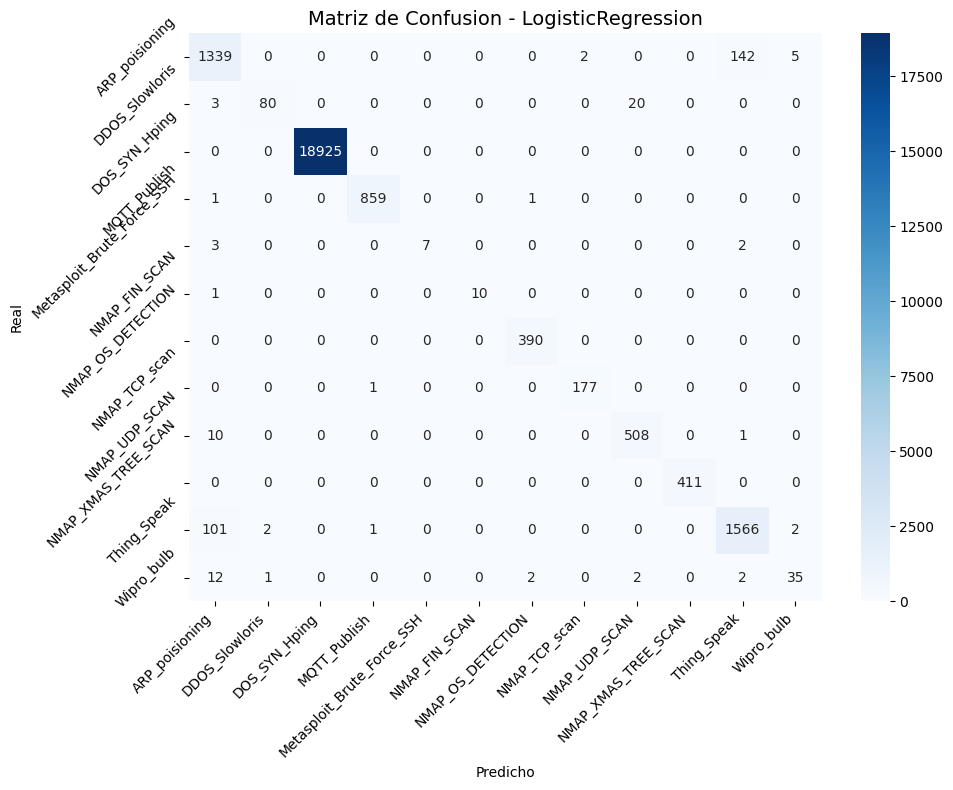


REPORTE COMPLETO - RandomForest
--------------------------------------------------
                            precision    recall  f1-score   support

            ARP_poisioning       0.99      1.00      0.99      1488
            DDOS_Slowloris       1.00      0.98      0.99       103
             DOS_SYN_Hping       1.00      1.00      1.00     18925
              MQTT_Publish       1.00      1.00      1.00       861
Metasploit_Brute_Force_SSH       1.00      0.67      0.80        12
             NMAP_FIN_SCAN       1.00      0.91      0.95        11
         NMAP_OS_DETECTION       1.00      1.00      1.00       390
             NMAP_TCP_scan       1.00      1.00      1.00       178
             NMAP_UDP_SCAN       0.99      0.99      0.99       519
       NMAP_XMAS_TREE_SCAN       1.00      1.00      1.00       411
               Thing_Speak       1.00      1.00      1.00      1672
                Wipro_bulb       1.00      0.94      0.97        54

                  accuracy    

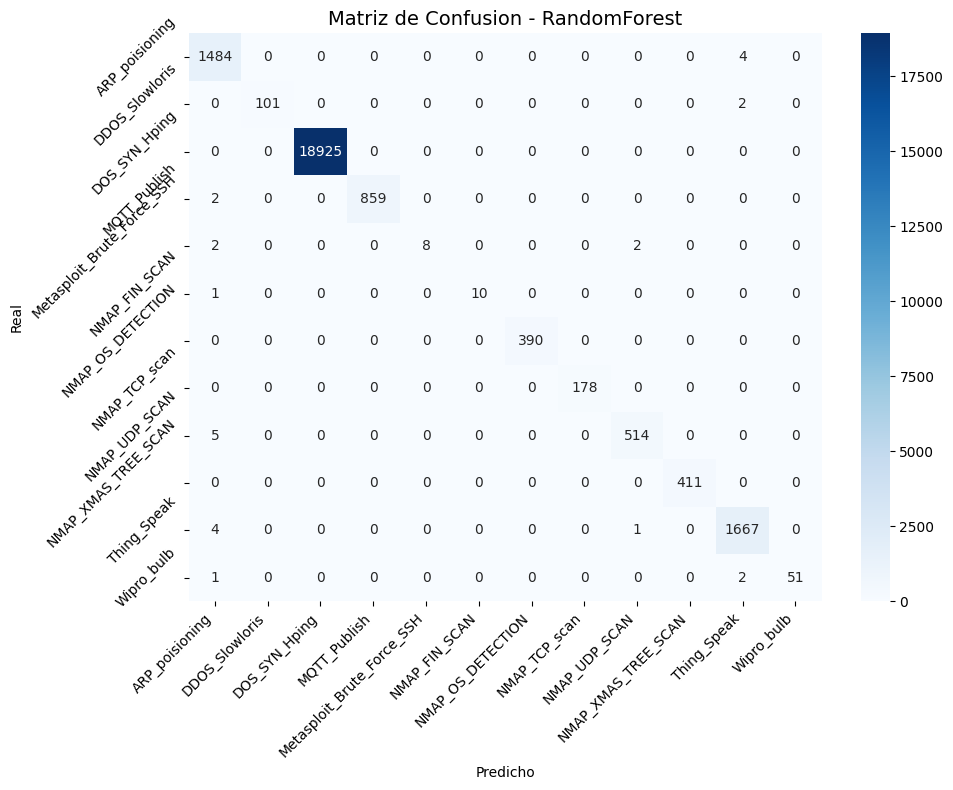


REPORTE COMPLETO - SVM_Linear_Optimized
--------------------------------------------------
                            precision    recall  f1-score   support

            ARP_poisioning       0.90      0.84      0.87      1488
            DDOS_Slowloris       0.95      0.78      0.86       103
             DOS_SYN_Hping       1.00      1.00      1.00     18925
              MQTT_Publish       1.00      0.99      0.99       861
Metasploit_Brute_Force_SSH       0.00      0.00      0.00        12
             NMAP_FIN_SCAN       0.83      0.91      0.87        11
         NMAP_OS_DETECTION       0.99      1.00      0.99       390
             NMAP_TCP_scan       0.98      0.99      0.99       178
             NMAP_UDP_SCAN       0.95      0.98      0.96       519
       NMAP_XMAS_TREE_SCAN       1.00      1.00      1.00       411
               Thing_Speak       0.87      0.93      0.90      1672
                Wipro_bulb       0.91      0.54      0.67        54

                  accu

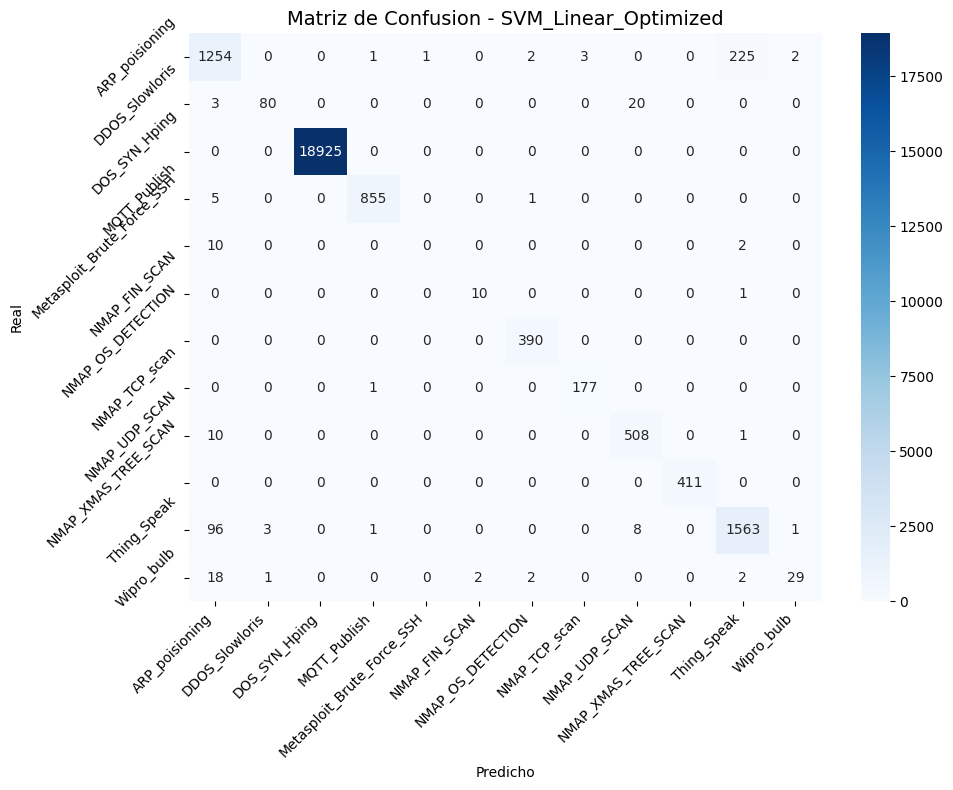


REPORTE COMPLETO - DecisionTree
--------------------------------------------------
                            precision    recall  f1-score   support

            ARP_poisioning       0.98      0.99      0.99      1488
            DDOS_Slowloris       0.98      0.98      0.98       103
             DOS_SYN_Hping       1.00      1.00      1.00     18925
              MQTT_Publish       1.00      1.00      1.00       861
Metasploit_Brute_Force_SSH       0.80      0.67      0.73        12
             NMAP_FIN_SCAN       0.77      0.91      0.83        11
         NMAP_OS_DETECTION       1.00      1.00      1.00       390
             NMAP_TCP_scan       1.00      1.00      1.00       178
             NMAP_UDP_SCAN       1.00      0.99      0.99       519
       NMAP_XMAS_TREE_SCAN       1.00      1.00      1.00       411
               Thing_Speak       1.00      0.99      0.99      1672
                Wipro_bulb       0.98      0.93      0.95        54

                  accuracy    

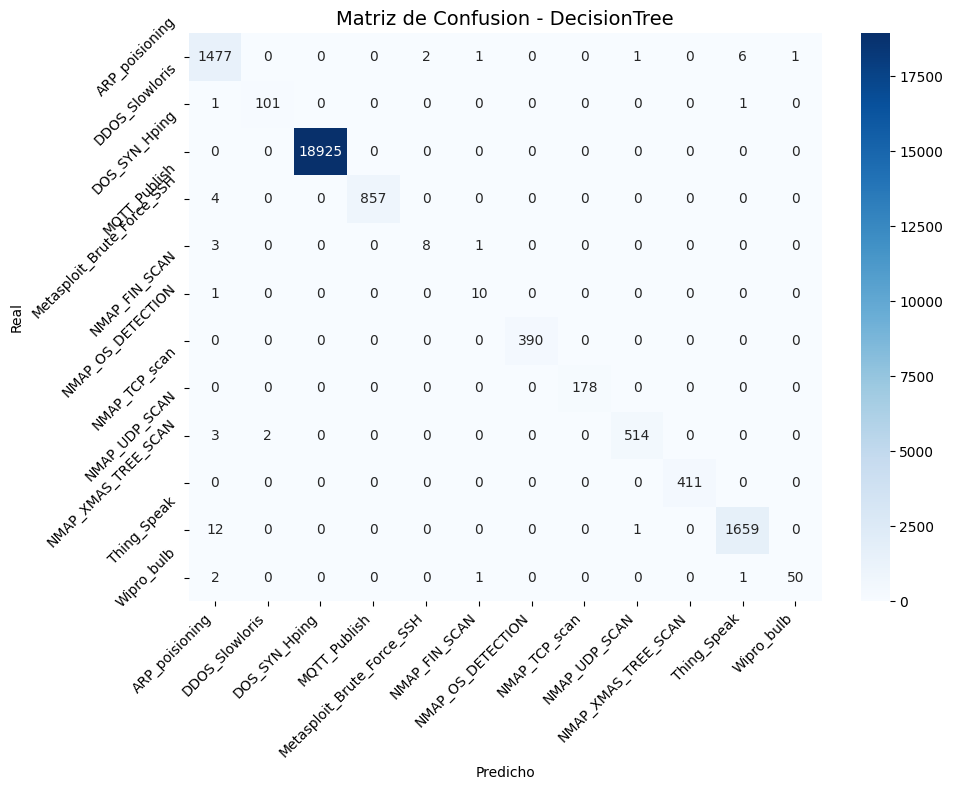


REPORTE COMPLETO - KNN
--------------------------------------------------
                            precision    recall  f1-score   support

            ARP_poisioning       0.97      0.99      0.98      1488
            DDOS_Slowloris       0.97      0.97      0.97       103
             DOS_SYN_Hping       1.00      1.00      1.00     18925
              MQTT_Publish       1.00      1.00      1.00       861
Metasploit_Brute_Force_SSH       1.00      0.58      0.74        12
             NMAP_FIN_SCAN       0.83      0.91      0.87        11
         NMAP_OS_DETECTION       0.99      1.00      1.00       390
             NMAP_TCP_scan       0.99      0.99      0.99       178
             NMAP_UDP_SCAN       1.00      0.98      0.99       519
       NMAP_XMAS_TREE_SCAN       1.00      1.00      1.00       411
               Thing_Speak       0.99      0.98      0.98      1672
                Wipro_bulb       0.90      0.87      0.89        54

                  accuracy             

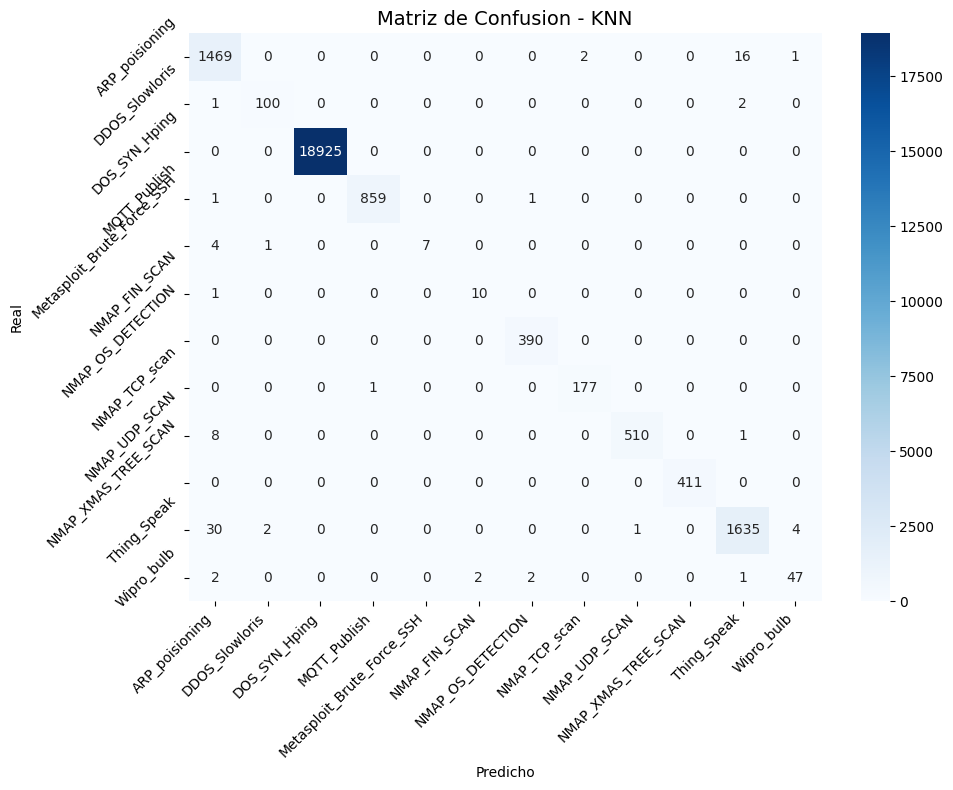

Reportes completos generados


In [14]:
# Generar reportes detallados después del entrenamiento
if hasattr(classifier, "results") and classifier.results and "y_test" in locals():
    classifier.generate_complete_reports(X_test, y_test)
    print("Reportes completos generados")
else:
    print("No hay resultados para generar reportes")

In [15]:
# Validación cruzada optimizada
if "X_train" in locals() and "y_train" in locals():
    cv_results = classifier.cross_validation_optimized(X_train, y_train, cv=3)
    print("Validación cruzada completada")
else:
    print("No hay datos para validación cruzada")


VALIDACION CRUZADA OPTIMIZADA


/home/lincj/.local/lib/python3.14/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/home/lincj/.local/lib/python3.14/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/lincj/.local/lib/python3.14/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Resultados de Validación Cruzada:
  LogisticRegression: 0.9860 (+/- 0.0015)
  RandomForest: 0.9983 (+/- 0.0001)
  SVM_Linear_Optimized: 0.9792 (+/- 0.0040)
  DecisionTree: 0.9977 (+/- 0.0004)
  KNN: 0.9956 (+/- 0.0003)
Validación cruzada completada


/home/lincj/.local/lib/python3.14/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



RESUMEN FINAL OPTIMIZADO
              Modelo  Accuracy  Tiempo_Entrenamiento(s)  Tiempo_Prediccion(s)
        RandomForest  0.998944                 1.700229              0.064790
        DecisionTree  0.998213                 0.890325              0.008258
                 KNN  0.996589                 0.061562              2.334483
  LogisticRegression  0.987126                18.236628              0.003852
SVM_Linear_Optimized  0.982862                74.522969              0.006595


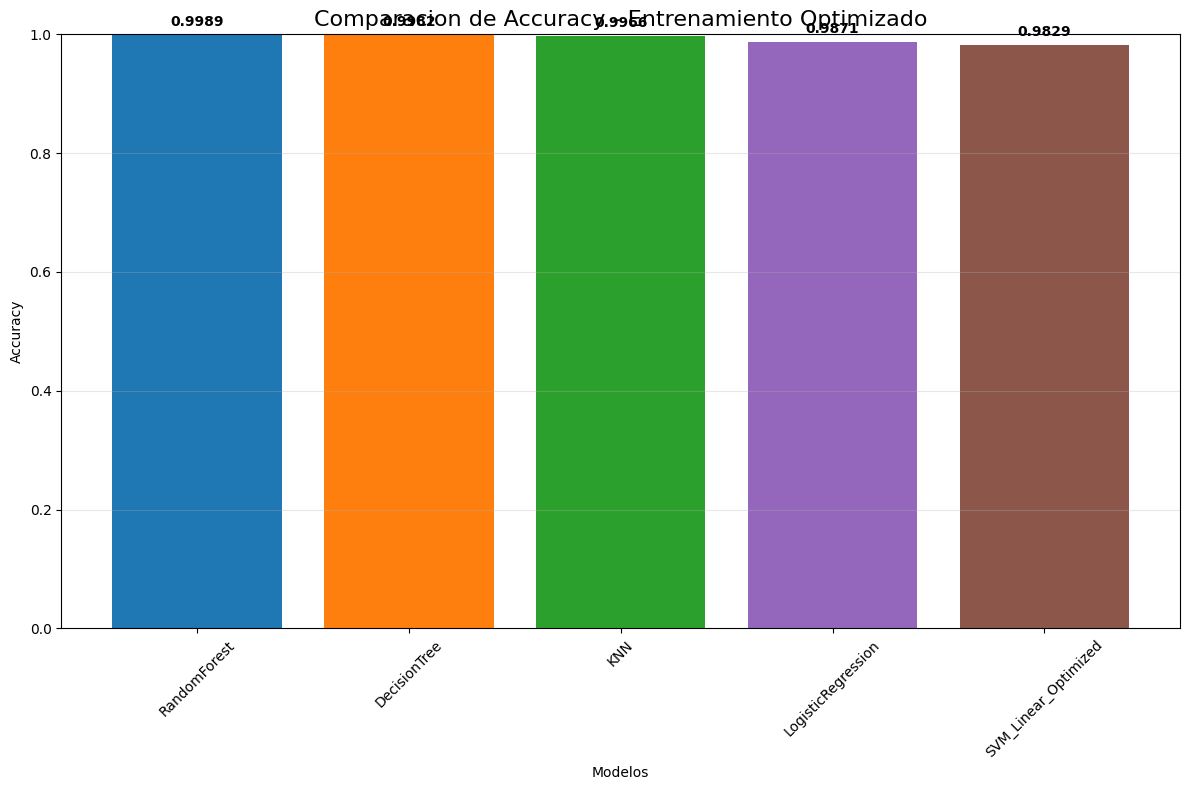


MEJOR MODELO: RandomForest (Accuracy: 0.9989)


In [16]:
# Resumen final optimizado
if hasattr(classifier, "results") and classifier.results:
    print("\n" + "=" * 70)
    print("RESUMEN FINAL OPTIMIZADO")
    print("=" * 70)

    results_data = []
    for model_name, result in classifier.results.items():
        results_data.append(
            {
                "Modelo": model_name,
                "Accuracy": result["accuracy"],
                "Tiempo_Entrenamiento(s)": result.get("training_time", "N/A"),
                "Tiempo_Prediccion(s)": result["prediction_time"],
            }
        )

    results_df = pd.DataFrame(results_data).sort_values("Accuracy", ascending=False)
    print(results_df.to_string(index=False))

    # Gráfico comparativo
    plt.figure(figsize=(12, 8))
    models = results_df["Modelo"]
    accuracies = results_df["Accuracy"]

    bars = plt.bar(
        models,
        accuracies,
        color=["#1f77b4", "#ff7f0e", "#2ca02c", "#9467bd", "#8c564b"],
    )
    plt.title("Comparacion de Accuracy - Entrenamiento Optimizado", fontsize=16)
    plt.xlabel("Modelos")
    plt.ylabel("Accuracy")
    plt.xticks(rotation=45)
    plt.ylim(0, 1)
    plt.grid(axis="y", alpha=0.3)

    for bar, accuracy in zip(bars, accuracies):
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 0.01,
            f"{accuracy:.4f}",
            ha="center",
            va="bottom",
            fontweight="bold",
        )

    plt.tight_layout()
    plt.show()

    best_model_name = results_df.iloc[0]["Modelo"]
    best_accuracy = results_df.iloc[0]["Accuracy"]
    print(f"\nMEJOR MODELO: {best_model_name} (Accuracy: {best_accuracy:.4f})")